In [35]:
## Bibliotecas 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
import pickle
pd.set_option('display.max_columns',None)
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [36]:
# Cargamos los 3 años de datos 

data_2018 = pd.read_csv('./data/ground_water_quality_2018_post.csv')
data_2019 = pd.read_csv('./data/ground_water_quality_2019_post.csv')
data_2020 = pd.read_csv('./data/ground_water_quality_2020_post.csv') 

In [37]:
# Revisamos si la bases de datos estan compuestas por la misma cantidad de columnas 

print(data_2018.shape)
print(data_2019.shape)
print(data_2020.shape)

(374, 26)
(364, 26)
(368, 27)


### Transformación de los datos 

In [38]:
# Agrupamos todas la limpeza de datos en una única función 
def transform_data(data_2018, data_2019, data_2020):
    # Eliminar columnas "season" de los DataFrames
    for df in [data_2018, data_2019,data_2020]:
        if 'season' in df.columns:
            df.drop("season", axis=1, inplace=True)
    
    # Eliminar la columna "Unnamed: 8" del DataFrame de 2020
    if 'Unnamed: 8' in data_2020.columns:
        data_2020.drop("Unnamed: 8", axis=1, inplace=True)
    
    # Agregar la columna 'anyo' a cada DataFrame
    data_2018['anyo'] = 2018
    data_2019['anyo'] = 2019
    data_2020['anyo'] = 2020
    
    # Renombrar columnas según el diccionario
    column_name = {'CO_-2 ': 'CO3', 'HCO_ - ': 'HCO3', 'Cl -': 'Cl', 'F -': 'F', 'NO3- ': 'NO3 ', 
                   'SO4-2': 'SO4', 'Na+': 'Na', 'K+': 'K', 'Ca+2': 'Ca', 'Mg+2': 'Mg', 'EC': 'E.C'}
    data_2019.rename(columns=column_name, inplace=True)
    
    # Actualizar un valor específico en data_2020
    data_2020.at[261, 'pH'] = 8.05
    
    # Calcular las medias de la columna "CO3" por distrito en 2018, 2019 y 2020
    mean_co3_2018 = data_2018.groupby('district')['CO3'].mean()
    mean_co3_2019 = data_2019.groupby('district')['CO3'].mean()
    mean_co3_2020 = data_2020.groupby('district')['CO3'].mean()
    
    # Crear un diccionario para mapear las medias por distrito en 2019
    co3_mean_dict_2019 = mean_co3_2019.to_dict()
    
    # Sustituir los valores nulos en 2019 con las medias por distrito de 2019
    data_2019['CO3'].fillna(data_2019['district'].map(co3_mean_dict_2019), inplace=True)
    
    # Concatenar los DataFrames data_2018 y data_2019 en data_agua
    data_agua = pd.concat([data_2018, data_2019, data_2020])
    
    col_eliminar= ['sno', 'district', 'mandal', 'village', 'lat_gis', 'long_gis','RSC  meq  / L','Classification.1', 'anyo']
    data_agua=data_agua.drop(columns=col_eliminar)

    # LAs clasificaciones OG, O.G, C3S4 y C2S2 solo continene 1 registro cada una. Causan demasiado ruido, por tanto las eliminamos  
    data_agua = data_agua[~data_agua['Classification'].isin(['C3S4', 'C2S2','OG','O.G'])]
    
    # Calcular la media de la columna 'CO3'
    mean_co3 = data_agua['CO3'].mean()
    
    # Sustituir los valores nulos en 'CO3' con la media de la columna 'CO3'
    data_agua['CO3'].fillna(mean_co3, inplace=True)
    
    # Sustituir los valores nulos en 'gwl' con la media de la columna 'gwl'
    data_agua['gwl'].fillna(data_agua['gwl'].mean(), inplace=True)
    
    # # Sustituir los valores nulos en 'gwl' de data_2020 con la media de la columna 'gwl'
    # data_2020['gwl'].fillna(data_2020['gwl'].mean(), inplace=True)
    
    return data_2018, data_2019, data_2020, data_agua

# Llama a la función con tus DataFrames
data_2018, data_2019, data_2020, data_agua = transform_data(data_2018, data_2019, data_2020)


In [39]:
data_agua.shape

(1100, 17)

In [40]:
# Configurar el modelo para predecir la clasificación CES1(1) u otra(0), escalar las numéricas por un minmaxScaler o un estandarAcaler o RobustScaler  

data_agua['Classification'].value_counts()

Classification
C3S1    696
C2S1    248
C4S1     87
C4S2     36
C3S2     12
C4S4      7
C3S3      6
C4S3      5
C1S1      3
Name: count, dtype: int64

### Entrenaremos nuestro modelo para predecir las Clasificación de la calidad del agua para el riego y bebederos de animales

* C1S1 : Las aguas bajas en salinidad y sodio son buenas para el riego y se pueden utilizar con la mayoría de los cultivos sin restricciones de uso en la mayoría de los suelos.

* C2S1 : Las aguas de salinidad media y bajo contenido de sodio son buenas para el riego y se pueden utilizar en casi todos los suelos con poco peligro de que se desarrollen niveles nocivos de sodio intercambiable si se produce una cantidad moderada de lixiviación. Los cultivos se pueden cultivar sin ninguna consideración especial para el control de la salinidad.

* C3S1 : Las aguas de alta salinidad y bajo contenido de sodio requieren un buen drenaje.
Se deben seleccionar cultivos con buena tolerancia a la sal.

* C3S2 : Las aguas de alta salinidad y sodio medio requieren un buen drenaje y pueden usarse
en suelos de textura gruesa u orgánicos que tengan buena permeabilidad.

* C3S3 : Estas aguas de alta salinidad y alto contenido de sodio requieren un manejo especial del suelo, buen drenaje, alta lixiviación y adiciones de materia orgánica. Las enmiendas de yeso viabilizan el aprovechamiento de estas aguas.

* C4S1 : Las aguas de muy alta salinidad y bajo contenido de sodio no son aptas para el riego a menos que el suelo deba ser permeable y el drenaje sea el adecuado. Las aguas de riego deben aplicarse en exceso para proporcionar una lixiviación considerable. Se deben seleccionar cultivos tolerantes a la sal.

* C4S2 : Las aguas de salinidad muy alta y sodio medio no son adecuadas para riego en
suelos de textura fina y condiciones de baja lixiviación y pueden usarse para riego en
suelos de textura gruesa u orgánicos que tengan buena permeabilidad.

* C4S3 : Las aguas con salinidad muy alta y alto contenido de sodio producen niveles nocivos de sodio intercambiable en la mayoría de los suelos y requerirán un manejo especial del suelo, buen drenaje, alta lixiviación y adiciones de materia orgánica. La enmienda Gypsum viabiliza el uso de estas aguas.

* C4S4 : Las aguas con muy alta salinidad y muy alto contenido de sodio generalmente no son aptas para fines de riego. Estos son tipos de agua con cloruro de sodio y pueden causar
riesgos de sodio. Se puede utilizar en suelos de textura gruesa con muy buen drenaje para cultivos muy tolerantes a la sal. Las enmiendas de yeso viabilizan el aprovechamiento de estas aguas.

In [41]:
data_agua.describe().T

,count,mean,std,min,25%,50%,75%,max
gwl,1100.0,8.578972,7.482310,0.170000,3.070000,5.985000,12.242500,43.170000
E.C,1100.0,1346.973636,823.633724,205.000000,781.750000,1173.500000,1666.250000,9499.000000
TDS,1100.0,862.063127,527.125583,131.200000,500.320000,751.040000,1066.400000,6079.360000
CO3,1100.0,9.077397,18.088463,0.000000,0.000000,0.000000,9.077397,100.000000
HCO3,1100.0,298.835567,131.092532,30.000000,200.000000,290.000000,377.271432,1070.000000
Cl,1100.0,190.763636,190.276745,10.000000,60.000000,130.000000,260.000000,2480.000000
F,1100.0,1.111998,0.776067,0.040000,0.620000,0.930000,1.420000,7.700000
NO3,1100.0,74.811746,97.209797,0.097438,17.749218,41.652732,95.713710,1028.000000
SO4,1100.0,40.078818,54.041264,1.000000,14.000000,23.000000,41.000000,860.000000
Na,1100.0,120.661315,103.109960,5.076154,55.438853,92.935000,150.971518,748.100000


In [42]:
data_agua.isnull().sum()

gwl               0
pH                0
E.C               0
TDS               0
CO3               0
HCO3              0
Cl                0
F                 0
NO3               0
SO4               0
Na                0
K                 0
Ca                0
Mg                0
T.H               0
SAR               0
Classification    0
dtype: int64

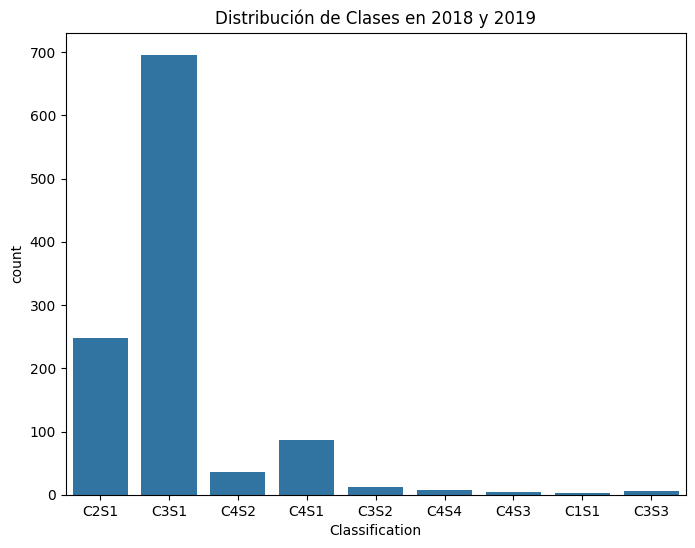

In [43]:
# Graficamos un Histograma para entender la distribución de las clases 

plt.figure(figsize=(8, 6))
sns.countplot(x='Classification', data=data_agua)
plt.title('Distribución de Clases en 2018 y 2019')
plt.show()

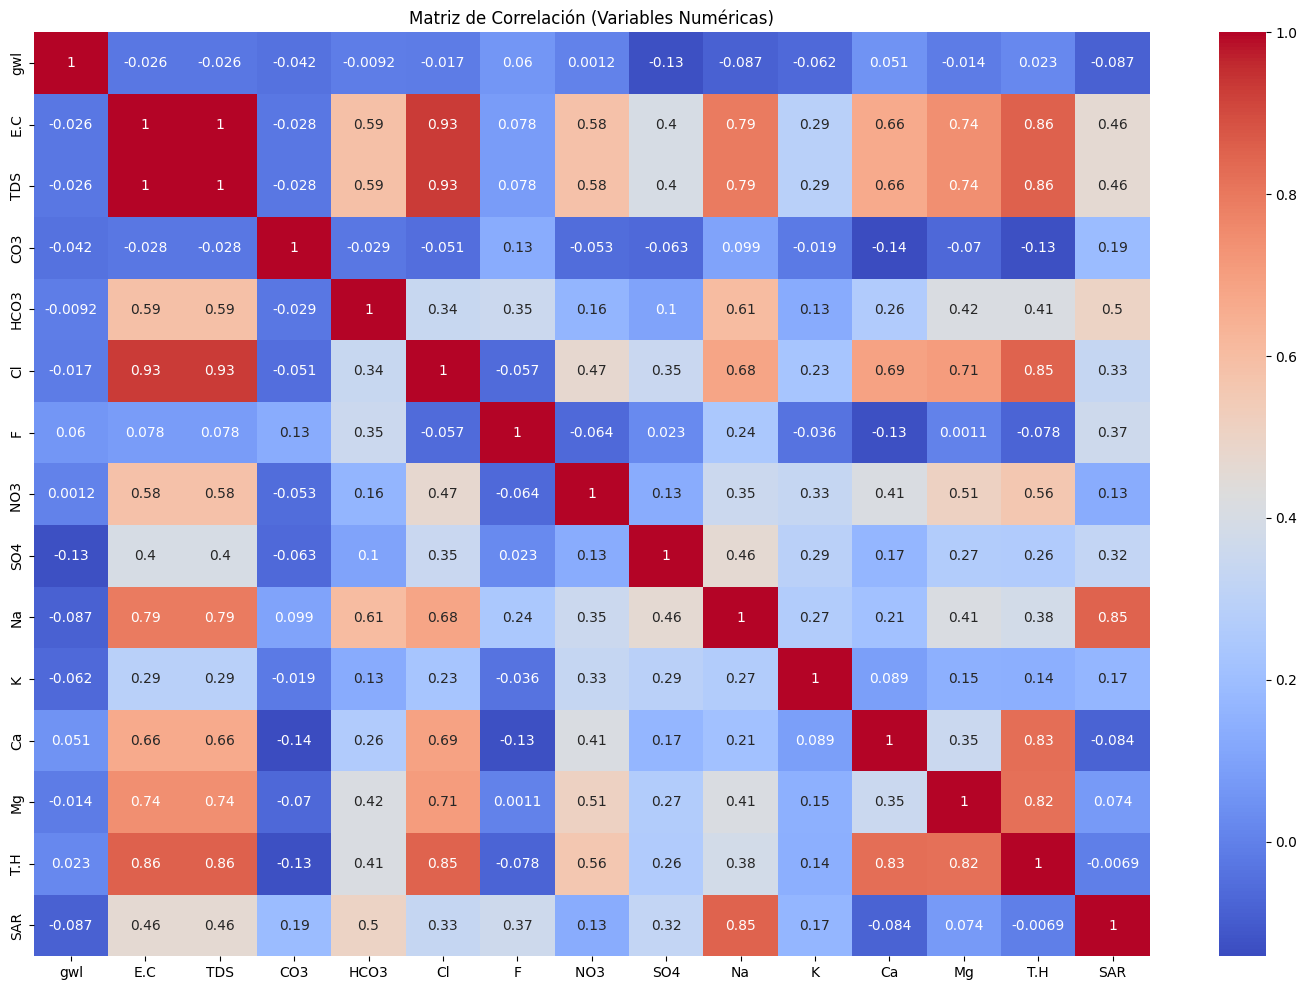

In [44]:
# Verificamos la correlación que existe entre las variables 

# variables numéricas
numeric_features = data_agua.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación entre las variables numéricas
correlation_matrix = numeric_features.corr()

# Crear una figura para la visualización
plt.figure(figsize=(18, 12))

# Visualizar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación (Variables Numéricas)')
plt.show()

In [45]:
data_agua['Classification'].unique()

array(['C2S1', 'C3S1', 'C4S2', 'C4S1', 'C3S2', 'C4S4', 'C4S3', 'C1S1',
       'C3S3'], dtype=object)

### Función Modelos 

In [46]:
def modelos_ML(data_agua):
    X = data_agua.drop(['Classification'], axis=1)
    y = data_agua['Classification']

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    # Normalizacion de los datos 
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=12)
    X_train_pca = pca.fit_transform(X_train_normalized)
    X_test_pca = pca.transform(X_test_normalized)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier()
    dt_classifier.fit(X_train_pca, y_train)
    dt_predictions = dt_classifier.predict(X_test_pca)
    dt_accuracy = accuracy_score(y_test, dt_predictions)

    # Random Forest Classifier
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(X_train_pca, y_train)
    rf_predictions = rf_classifier.predict(X_test_pca)
    rf_accuracy = accuracy_score(y_test, rf_predictions)

    # Support Vector Classifier
    svc_classifier = SVC()
    svc_classifier.fit(X_train_pca, y_train)
    svc_predictions = svc_classifier.predict(X_test_pca)
    svc_accuracy = accuracy_score(y_test, svc_predictions)

    # K-Nearest Neighbors
    knn_classifier = KNeighborsClassifier()
    knn_classifier.fit(X_train_pca, y_train)
    knn_predictions = knn_classifier.predict(X_test_pca)
    knn_accuracy = accuracy_score(y_test, knn_predictions)

     # Guarda los modelos en archivos .pkl
    with open('models/decision_tree_model.pkl', 'wb') as file:
        pickle.dump(dt_classifier, file)

    with open('models/random_forest_model.pkl', 'wb') as file:
        pickle.dump(rf_classifier, file)

    with open('models/svm_model.pkl', 'wb') as file:
        pickle.dump(svc_classifier, file)

    with open('models/knn_model.pkl', 'wb') as file:
        pickle.dump(knn_classifier, file)

    return {
        "explained_variance_ratio": explained_variance_ratio,
        "decision_tree_accuracy": dt_accuracy,
        "random_forest_accuracy": rf_accuracy,
        "svc_accuracy": svc_accuracy,
        "knn_accuracy": knn_accuracy,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "X_train_pca": X_train_pca,
        "X_test_pca": X_test_pca,  
        "dt_predictions": dt_predictions,
        "X": X
    }
    
   
# Llama a la función con tu conjunto de datos Water_data
resultados = modelos_ML(data_agua)
print("Explained Variance Ratio:", resultados["explained_variance_ratio"])
print("Decision Tree Accuracy:", resultados["decision_tree_accuracy"])
print("Random Forest Accuracy:", resultados["random_forest_accuracy"])
print("SVC Accuracy:", resultados["svc_accuracy"])
print("K-NN Accuracy:", resultados["knn_accuracy"])

Explained Variance Ratio: [0.40800997 0.15164032 0.08547836 0.07784587 0.06031094 0.04571196
 0.04310894 0.04143109 0.03460739 0.02548249 0.02087367 0.00445415]
Decision Tree Accuracy: 0.8939393939393939
Random Forest Accuracy: 0.9212121212121213
SVC Accuracy: 0.9030303030303031
K-NN Accuracy: 0.8757575757575757


In [47]:
X_train_pca = resultados['X_train']
X_train_pca.columns

Index(['gwl', 'pH', 'E.C', 'TDS', 'CO3', 'HCO3', 'Cl', 'F', 'NO3 ', 'SO4',
       'Na', 'K', 'Ca', 'Mg', 'T.H', 'SAR'],
      dtype='object')

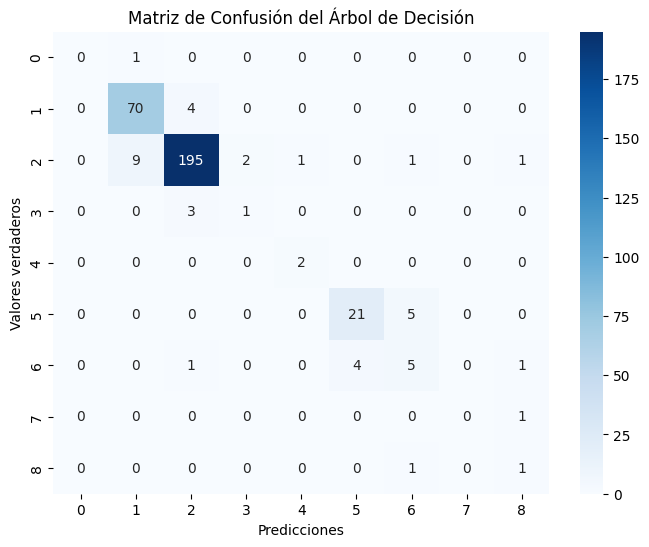

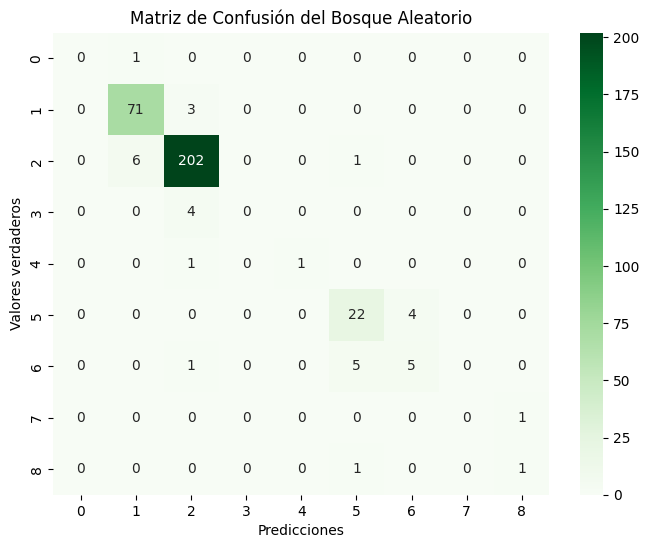

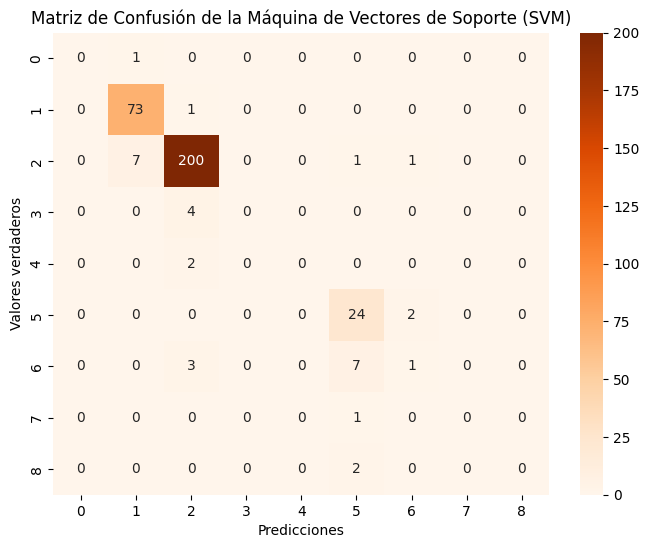

In [48]:
# Llama a la función para entrenar y evaluar los modelos
resultados = modelos_ML(data_agua)

# Resultados de la función
explained_variance_ratio = resultados["explained_variance_ratio"]
dt_accuracy = resultados["decision_tree_accuracy"]
rf_accuracy = resultados["random_forest_accuracy"]
svc_accuracy = resultados["svc_accuracy"]
knn_accuracy = resultados["knn_accuracy"]

# Cargar los modelos desde los archivos .pkl
with open('models/decision_tree_model.pkl', 'rb') as file:
    dt_classifier = pickle.load(file)

with open('models/random_forest_model.pkl', 'rb') as file:
    rf_classifier = pickle.load(file)

with open('models/svm_model.pkl', 'rb') as file:
    svc_classifier = pickle.load(file)

# Obtener predicciones con los modelos cargados
dt_predictions = dt_classifier.predict(resultados["X_test_pca"])
rf_predictions = rf_classifier.predict(resultados["X_test_pca"])
svc_predictions = svc_classifier.predict(resultados["X_test_pca"])

# Crear y visualizar la matriz de confusión para el Árbol de Decisión
confusion_dt = confusion_matrix(resultados["y_test"], dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_dt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión del Árbol de Decisión')
plt.show()

# Crear y visualizar la matriz de confusión para el Bosque Aleatorio
confusion_rf = confusion_matrix(resultados["y_test"], rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión del Bosque Aleatorio')
plt.show()

# Crear y visualizar la matriz de confusión para la Máquina de Vectores de Soporte (SVM)
confusion_svm = confusion_matrix(resultados["y_test"], svc_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_svm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión de la Máquina de Vectores de Soporte (SVM)')
plt.show()


### Realizamos las predicciones 

In [49]:
# Cargamos los modelos previamente entrenados
def cargar_modelos():
    decision_tree_model = pickle.load(open('models/decision_tree_model.pkl', 'rb'))
    random_forest_model = pickle.load(open('models/random_forest_model.pkl', 'rb'))
    svc_model = pickle.load(open('models/svm_model.pkl', 'rb'))
    knn_model = pickle.load(open('models/knn_model.pkl', 'rb'))
    
    return decision_tree_model, random_forest_model, svc_model, knn_model

def predecir_con_modelos(modelos, datos_entrada):
    decision_tree_model, random_forest_model, svc_model, knn_model = modelos

    # Predecimos con los cuatro modelos
    predicciones_decision_tree = decision_tree_model.predict(datos_entrada)
    predicciones_random_forest = random_forest_model.predict(datos_entrada)
    predicciones_svc = svc_model.predict(datos_entrada)
    predicciones_knn = knn_model.predict(datos_entrada)

    return {
        "Decision Tree Predictions": predicciones_decision_tree,
        "Random Forest Predictions": predicciones_random_forest,
        "SVC Predictions": predicciones_svc,
        "K-NN Predictions": predicciones_knn
    }


In [50]:
# Obtener las características utilizadas por el modelo
caracteristicas_utilizadas = rf_classifier.feature_importances_

# Obtener los nombres de las columnas correspondientes a las características utilizadas
columnas = data_agua.columns  # Donde X es tu conjunto de datos original (data_agua en tu caso)

# Crear una lista de tuplas que contenga el nombre de la columna y su importancia
importancia_de_caracteristicas = list(zip(columnas, caracteristicas_utilizadas))

# Ordenar la lista en función de la importancia en orden descendente
importancia_de_caracteristicas.sort(key=lambda x: x[1], reverse=True)

# Mostrar las características y sus importancias
for caracteristica, importancia in importancia_de_caracteristicas:
    print(f'{caracteristica}: {importancia}')


gwl: 0.5633315933266997
K: 0.07221030539642621
pH: 0.05748663096571702
E.C: 0.049821118213462995
F: 0.04458960139799272
HCO3: 0.035906214869996594
NO3 : 0.035708358862683365
TDS: 0.03458322492089885
SO4: 0.030668174454567588
Na: 0.026507607597627412
CO3: 0.02634799599412025
Cl: 0.022839173999807335
